In [1]:
from PIL import Image, ImageDraw, ImageFilter
import random
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Input, Convolution2D,MaxPooling2D,AveragePooling2D,Flatten,Dropout
from keras import optimizers
from tqdm import tqdm
import matplotlib.patches as patches
plt.rcParams["figure.figsize"] = (8,6)


Using TensorFlow backend.


In [2]:
backgrounds_folder='./backgrounds'
signs_folder='./signs'
backgrounds=os.listdir(backgrounds_folder)
signs=os.listdir(signs_folder)
print(len(backgrounds), ' backgrounds')
print(len(signs), ' signs')

8  backgrounds
207  signs


### Generate data

In [3]:
canvas_size=(400,300)
sign_size_min=100
sign_size_max=150

In [4]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

In [5]:
for i in tqdm(range(2000)):
    #pick random sign
    sign_index=random.randint(0,len(signs)-1)
    sign=Image.open(signs_folder+'/'+signs[sign_index])
    size=random.randint(sign_size_min,sign_size_max)
    sign=sign.resize((size,size))
    #pick random background
    background_index=random.randint(0,len(backgrounds)-1)
    background=Image.open(backgrounds_folder+'/'+backgrounds[background_index])
    background=background.resize(canvas_size)
    #mask
    mask_im = Image.new("L", sign.size, 0)
    draw = ImageDraw.Draw(mask_im)
    draw.ellipse((0, 0, sign.size[0], sign.size[1]), fill=255)
    mask_im_blur = mask_im.filter(ImageFilter.GaussianBlur(5))
    top_left_x=random.randint(0,background.size[0]-sign.size[0])
    top_left_y=random.randint(0,background.size[1]-sign.size[1])
    background.paste(sign, (top_left_x, top_left_y), mask_im_blur)
    label=[top_left_x, top_left_y,top_left_x+sign.size[0], top_left_y+sign.size[1]]
    if i <1900:
        x_train+=[np.array(background)]
        y_train+=[label]
    else:
        x_test+=[np.array(background)]
        y_test+=[label]

100%|██████████| 2000/2000 [01:09<00:00, 28.60it/s]


In [6]:
def plot(X,Y):
    plt.imshow(X)
    padding=0
    plt.scatter([Y[0],Y[2],Y[0],Y[2]],\
                [Y[1],Y[3],Y[3],Y[1]],c='red')
    ax = plt.gca()
    ax.add_patch(patches.Rectangle((Y[0],Y[1]),Y[2]-Y[0],Y[3]-Y[1],linewidth=2,edgecolor='r',facecolor='none'))
    return plt

In [7]:
x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [8]:
#x_train = x_train.reshape(x_train.shape[0], canvas_size[0], canvas_size[1],3)
#x_test = x_test.reshape(x_test.shape[0],  canvas_size[0], canvas_size[1],3)

#Normalization
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
y_train = y_train.astype('float32')/max(canvas_size)
y_test = y_test.astype('float32')/max(canvas_size)

### Define and train model

In [9]:
model = Sequential()
model.add(MaxPooling2D(pool_size=(4,4),input_shape=(canvas_size[1], canvas_size[0],3)))
model.add(Convolution2D(14, (3,3),activation='relu'))
model.add(Convolution2D(14, (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(10, (3,3),activation='relu'))
model.add(Convolution2D(10, (3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(4,activation='relu'))
model.build()

In [10]:
model.compile(optimizer='adam',loss='mse')

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_1 (MaxPooling2 (None, 75, 100, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 98, 14)        392       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 96, 14)        1778      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 48, 14)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 46, 10)        1270      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 31, 44, 10)        910       
_________________________________________________________________
flatten_1 (Flatten)          (None, 13640)            

In [12]:
history=model.fit(x_train, y_train, epochs=40,validation_split=0.1, shuffle=True, verbose=1)

Train on 1710 samples, validate on 190 samples
Epoch 1/40
1710/1710 [==============================] - 26s 15ms/step - loss: 0.0442 - val_loss: 0.0272
Epoch 2/40
1710/1710 [==============================] - 23s 14ms/step - loss: 0.0182 - val_loss: 0.0122
Epoch 3/40
1710/1710 [==============================] - 15s 9ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 4/40
1710/1710 [==============================] - 21s 12ms/step - loss: 0.0057 - val_loss: 0.0064
Epoch 5/40
1710/1710 [==============================] - 17s 10ms/step - loss: 0.0048 - val_loss: 0.0060
Epoch 6/40
1710/1710 [==============================] - 15s 9ms/step - loss: 0.0039 - val_loss: 0.0054
Epoch 7/40
1710/1710 [==============================] - 15s 9ms/step - loss: 0.0036 - val_loss: 0.0050
Epoch 8/40
1710/1710 [==============================] - 14s 8ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 9/40
1710/1710 [==============================] - 14s 8ms/step - loss: 0.0026 - val_loss: 0.0046
Epoch 10/40
1710/1710 

KeyboardInterrupt: 

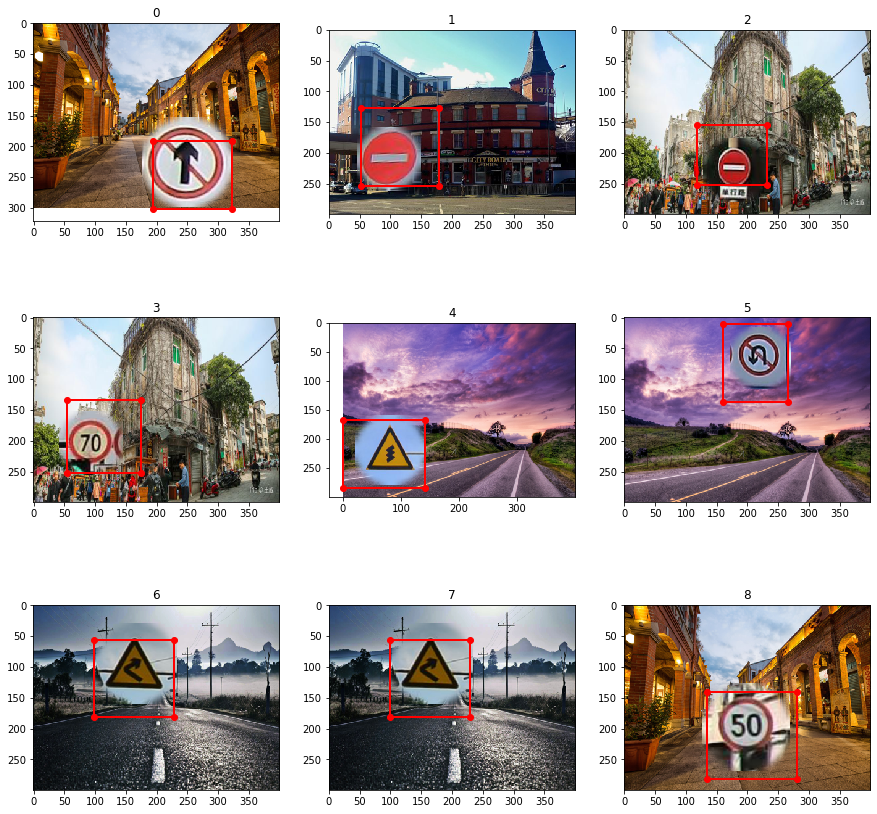

In [18]:
plt.figure(figsize=(15,15))
for i in range(9):
    ax= plt.subplot(3,3,i+1)
    k = random.randint(0,len(x_test))-1
    x=x_test[k]
    y=model.predict(np.array([x]))[0]
    im=plot(x,y*max(canvas_size))
    plt.title(i)